In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import missingno
import warnings

warnings.filterwarnings("ignore")


# 一、数据预处理

## 1.公共函数

In [2]:
import math
#可视化函数
def plot_distribution(dataset,cols=5,width=40,height=40,hspace=0.2,wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=wspace,hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i,column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows,cols,i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == object:
            g = sns.countplot(y=column,data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.rcParams['savefig.dpi'] = 1200 #图片像素
            plt.rcParams['figure.dpi'] = 1200 #分辨率
            plt.xticks(rotation=25)
        else:
            # g = sns.histplot(dataset[column],kde=True,stat='density')
            g = sns.distplot(dataset[column],kde=True)
            plt.rcParams['savefig.dpi'] = 1200 #图片像素
            plt.rcParams['figure.dpi'] = 1200 #分辨率
            plt.xticks(rotation=25)

## 2.导入数据并删除缺失值

age         workclass    fnlwgt  education  education-num  \
0  39         State-gov   77516.0  Bachelors           13.0   
1  50  Self-emp-not-inc   83311.0  Bachelors           13.0   
2  38           Private  215646.0    HS-grad            9.0   
3  53           Private  234721.0       11th            7.0   
4  28           Private  338409.0  Bachelors           13.0   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country  class  
0        2174.0           0.0            40.0  United-States  <=50K  
1           0.0           0.0            13.0  United-States  <=50K  
2           0.0           0.0            40.0  United-States  <=50K  
3           0.0           0.0            40.0  United-States  <=50K  
4           0.0           0.0            40.0           Cuba  <=50K

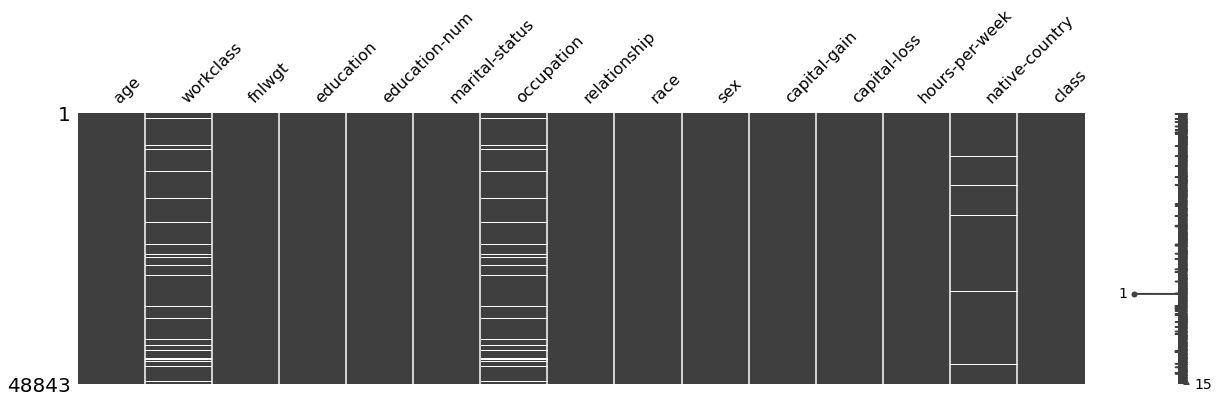

In [3]:
headers = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','class'] 
training_raw = pd.read_csv('dataset/adult.data',header=None,names=headers,sep=',\s',na_values=["?"],engine='python')
test_raw = pd.read_csv('dataset/adult.test',header=None,names=headers,sep=',\s',na_values=["?"],engine='python')
dataset_raw = training_raw.append(test_raw)
dataset_raw.reset_index(inplace=True)
dataset_raw.drop('index',inplace=True,axis=1)
missingno.matrix(dataset_raw,figsize=(20,5))
dataset_raw=dataset_raw.dropna() #删除缺失值
dataset_raw.head()

## 3.整体数据探索

In [4]:
dataset_raw.loc[dataset_raw["class"]=='<=50K.','class']='<=50K'
dataset_raw.loc[dataset_raw["class"]=='>50K.','class']='>50K'
# print(dataset_raw['class'].value_counts()) #收入数据分布情况
dataset_raw.describe() #数据整体描述

fnlwgt  education-num  capital-gain  capital-loss  hours-per-week
count  4.522200e+04   45222.000000  45222.000000  45222.000000    45222.000000
mean   1.897347e+05      10.118460   1101.430344     88.595418       40.938017
std    1.056392e+05       2.552881   7506.430084    404.956092       12.007508
min    1.349200e+04       1.000000      0.000000      0.000000        1.000000
25%    1.173882e+05       9.000000      0.000000      0.000000       40.000000
50%    1.783160e+05      10.000000      0.000000      0.000000       40.000000
75%    2.379260e+05      13.000000      0.000000      0.000000       45.000000
max    1.490400e+06      16.000000  99999.000000   4356.000000       99.000000

# 三、Race(种族)数据探索

## 1.探索种族分布

       capital-loss  capital-gain
count  45222.000000  45222.000000
mean      88.595418   1101.430344
std      404.956092   7506.430084
min        0.000000      0.000000
25%        0.000000      0.000000
50%        0.000000      0.000000
75%        0.000000      0.000000
max     4356.000000  99999.000000
    race  capital-loss  capital-gain native-country  class
0  White           0.0        2174.0  United-States  <=50K
1  White           0.0           0.0  United-States  <=50K
2  White           0.0           0.0  United-States  <=50K
3  Black           0.0           0.0  United-States  <=50K
4  Black           0.0           0.0           Cuba  <=50K


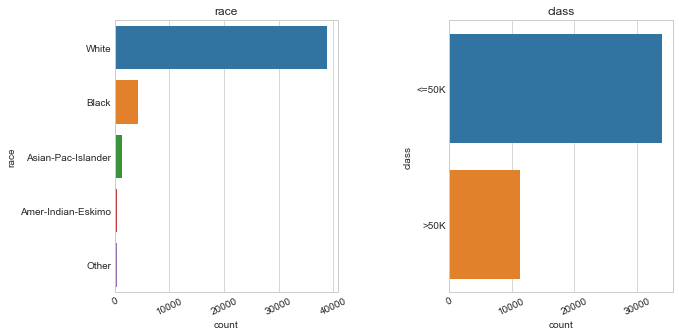

In [5]:
df = dataset_raw[["race","capital-loss","capital-gain","native-country","class"]]
print(df.describe())
plot_distribution(df[["race","class"]],cols=2,width=10,height=5,hspace=0.45,wspace=0.5)
print(df.head())

## 2.探索种族的收入占比情况

In [71]:
c = df.groupby(["race"],as_index=False).size()
d = df.groupby(["race","class"],as_index=False).size()
c.insert(c.shape[1],'>50K',0.0)
c.insert(c.shape[1],'<=50K',0.0)
for idx,r in c.iterrows():
    e = d[(d["class"]==">50K") & (d["race"]==r["race"])]
    if len(e)>0:
        c.iat[idx,2]=e["size"]/r["size"]
    e = d[(d["class"]=="<=50K") & (d["race"]==r["race"])]
    if len(e)>0:
        c.iat[idx,3]=e["size"]/r["size"]
c = c.sort_values(by=">50K")
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(18, 9))
sns.set_color_codes("pastel")
sns.barplot(x=c['race'],y=c['<=50K'],label='class<=50K',color="blue")
sns.barplot(x=c['race'],y=c['>50K'],label='class>50K',color="red")
ax.legend(ncol=1, loc="upper right", frameon=True)
plt.show()
c.describe()

size      >50K     <=50K
count      5.000000  5.000000  5.000000
mean    9044.400000  0.184236  0.815764
std    16765.479259  0.081192  0.081192
min      353.000000  0.121839  0.716807
25%      435.000000  0.126301  0.737629
50%     1303.000000  0.127479  0.872521
75%     4228.000000  0.262371  0.873699
max    38903.000000  0.283193  0.878161

# 四、资本收益与资本损失分析

## 1.资本损失/收益密度分析

In [31]:

df2 = df[["capital-gain"]][df["capital-gain"]>0]
print(df2.describe())
plot_distribution(df2,cols=1,width=10,height=5,hspace=0.45,wspace=0.5)
plt.show()
df2 = df[["capital-loss"]][df["capital-loss"]>0]
print(df2.describe())
plot_distribution(df2,cols=1,width=10,height=5,hspace=0.45,wspace=0.5)


       capital-gain
count   3790.000000
mean   13142.185488
std    22676.003955
min      114.000000
25%     3464.000000
50%     7298.000000
75%    14084.000000
max    99999.000000


       capital-loss
count   2140.000000
mean    1872.178505
std      355.224447
min      155.000000
25%     1672.000000
50%     1887.000000
75%     1977.000000
max     4356.000000


## 2.资本损益整体分析

In [59]:
print("资本收益统计")
print(df['capital-gain'][(df['capital-gain']!=0)].agg(['mean','count']))
print("-------------------------")
print("资本损失统计")
print(df['capital-loss'][(df['capital-loss']!=0)].agg(['mean','count']))

资本收益统计
mean     13142.185488
count     3790.000000
Name: capital-gain, dtype: float64
-------------------------
资本损失统计
mean     1872.178505
count    2140.000000
Name: capital-loss, dtype: float64


## 3.资本损益与Class分析

In [64]:
t = df[df['capital-loss']>0]
t2 = df[df['capital-gain']>0]
y1=[len(t[t['class']=='<=50K'])/len(t),len(t2[t2['class']=='<=50K'])/len(t2)]
y2=[1-y1[0],1-y1[1]]

x=["Capital-loss","Capital-gain"]
f, ax = plt.subplots(figsize=(13, 8))
sns.set_color_codes("pastel")
sns.barplot(x=x,y=y1,label='class<=50K',color="b",bottom=y2)
sns.barplot(x=x,y=y2,label='class>50K',color="r")
ax.legend(ncol=1, loc="upper right", frameon=True)

y2

[0.5130841121495326, 0.6266490765171504]

# 五、Native-country数据探索

## 1.Native-country整体探索

In [61]:
c = df['native-country'].value_counts()
c.describe()

count       41.000000
mean      1102.975610
std       6434.934815
min          1.000000
25%         29.000000
50%         69.000000
75%        113.000000
max      41292.000000
Name: native-country, dtype: float64

## 2.Native-country数据分析
增加新特征，新特征为某个国家收入>50k的人数占比，并用新特征进行可视化

In [66]:
c = df.groupby(["native-country"],as_index=False).size()
d = df.groupby(["native-country","class"],as_index=False).size()
c.insert(c.shape[1],'>50K',0.0)
for idx,r in c.iterrows():
    e = d[(d["class"]==">50K") & (d["native-country"]==r["native-country"])]
    if len(e)>0:
        c.iat[idx,2]=e["size"]/r["size"]
# c = c.sort_values(by=">50K")
plt.subplots(figsize=(15, 8))
plt.xticks(rotation=90)
sns.set_style("whitegrid")
sns.barplot(x=c["native-country"],y=c[">50K"])
plt.show()


## 3.Ntive-country数据描述

In [63]:
c.describe()

size  >50K
count     41.000000  41.0
mean    1102.975610   0.0
std     6434.934815   0.0
min        1.000000   0.0
25%       29.000000   0.0
50%       69.000000   0.0
75%      113.000000   0.0
max    41292.000000   0.0